### The purpose of this notebook is to predict based on diagnostic measurements whether a patient has diabetes. Because the response variable is qualitative, this is a classification problem.

####   Importing pandas library

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import binarize
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
import warnings


####    Reading the data into pandas frame

In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
data = pd.read_csv('C://Users//sambh//Downloads//diabetes.csv', header=None, names=col_names)

####     Examine the data

In [3]:
data.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0


In [4]:
data.shape

(769, 9)

In [5]:
data.dtypes

pregnant    object
glucose     object
bp          object
skin        object
insulin     object
bmi         object
pedigree    object
age         object
label       object
dtype: object

####    The data type of all the features is correct we will not change it

In [6]:
data.describe()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
count,769,769,769,769,769,769,769,769,769
unique,18,137,48,52,187,249,518,53,3
top,1,100,70,0,0,32,0.254,22,0
freq,135,17,57,227,374,13,6,72,500


####    We can observe from the statistics that the maximum value of insulin is above 3 standard deviations that means there are outliers in the insulin column so we will remove the data which is 2 standard deviations above

In [7]:
data['insulin'] = pd.to_numeric(data['insulin'], errors='coerce')


In [8]:
data.loc[data['insulin'] > 425] = np.nan

In [9]:
data.loc[((data['insulin'] > 425))] = np.nan 

In [10]:
data.isnull().sum()

pregnant    18
glucose     18
bp          18
skin        18
insulin     19
bmi         18
pedigree    18
age         18
label       18
dtype: int64

####   Since the dataset is small we can not drop the rows so, in this case we will use imputing method and replace the null value with mean

In [11]:
for f in ['pregnant', 
          'glucose', 
          'bp', 
          'skin',
          'insulin', 'bmi', 'pedigree', 'age', 'label']:
    
    
    data[f] = pd.to_numeric(data[f], errors='coerce')
    

    data.loc[data[f].isnull(), f] = data[f].mean()


In [12]:
data.isnull().sum()

pregnant    0
glucose     0
bp          0
skin        0
insulin     0
bmi         0
pedigree    0
age         0
label       0
dtype: int64

### Now our dataset is clean so we will start building the classification model

####  Prepare X and y in pandas

In [13]:
feature_cols = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']
X = data[feature_cols]
y = data.label

####   Split the dataset in training and test datset. Assign random sate variable in order to get same training and test dataset everytime

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [15]:

logreg = LogisticRegression()

####   Fit a logistic regression model

In [16]:
logreg.fit(X_train, y_train.astype(int))

C:\Users\sambh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

####  The regression coefficients and intercept

In [17]:
print(logreg.intercept_)
print(logreg.coef_)

[-8.00274923]
[[ 0.12839468  0.03598555 -0.01438781  0.00671926 -0.0027201   0.08505813
   0.99732916  0.00372816]]


####  Statistical summary of the model

In [18]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     42.00
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.05e-55
Time:                        13:25:09   Log-Likelihood:                -366.95
No. Observations:                 769   AIC:                             751.9
Df Residuals:                     760   BIC:                             793.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8642      0.084    -10.277      0.0

####  This is the summary of model with all the features included. The value of R squared indicates 30.7% variance is explained by this model. The P value for the feature Skin, insulin, age is more than 0.05 which is enough to accept the null hypothesis for these features. We need to make this model more accurate by selecting appropriate features.

## Feature Selection

#####  First Imporant feature 

In [19]:
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
for f in feature_cols:
    X = data[[f]]
    #X = X.values.reshape(-1, 1)
    cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
    print(f, cv_auc)

pregnant 0.6236764705882354
glucose 0.7839042232277527
bp 0.5947194570135746
skin 0.5482699849170437
insulin 0.51986802413273
bmi 0.696396681749623
pedigree 0.6046387631975867
age 0.6829622926093515


#### It is clear from the above result that glucose it the most important feature now wew will find second most imp feature

In [20]:
for f in feature_cols:
    if f not in ['glucose']:
        X = data[['glucose', f]]
        cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
        print(f, cv_auc)

pregnant 0.8010203619909502
bp 0.7829939668174962
skin 0.7796191553544495
insulin 0.7830052790346909
bmi 0.8121327300150829
pedigree 0.7926923076923076
age 0.7948491704374058


#### Now second most important feature is bmi lets find out third most important

In [21]:
for f in feature_cols:
    if f not in ['glucose', 'bmi']:
        X = data[['glucose', 'bmi', f]]
        cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
        print(f, cv_auc)

pregnant 0.8256530920060332
bp 0.8114947209653092
skin 0.809918552036199
insulin 0.8116817496229262
pedigree 0.8207737556561087
age 0.8199788838612369


#### Now third most important feature is pregnant lets find out fourth most important

In [22]:
for f in feature_cols:
    if f not in ['glucose', 'bmi', 'pregnant']:
        X = data[['glucose', 'bmi', 'pregnant', f]]
        cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
        print(f, cv_auc)

bp 0.8263906485671191
skin 0.8216983408748115
insulin 0.8232156862745098
pedigree 0.832420814479638
age 0.8233107088989442


#### Fourth most iportant feature is pedigree lets find fifth imp feature

In [23]:
for f in feature_cols:
    if f not in ['glucose', 'bmi', 'pregnant', 'pedigree']:
        X = data[['glucose', 'bmi', 'pregnant', 'pedigree', f]]
        cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
        print(f, cv_auc)

bp 0.8329110105580695
skin 0.8290874811463045
insulin 0.8329064856711914
age 0.829396681749623


#### Fifth most important feature is insulin let's find sixth imp feature

In [24]:
for f in feature_cols:
    if f not in ['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin']:
        X = data[['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin', f]]
        cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
        print(f, cv_auc)

bp 0.833156862745098
skin 0.8322232277526395
age 0.8304102564102565


#### Sixth feature would be bp and lets find the next one

In [25]:
for f in feature_cols:
    if f not in ['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin', 'bp']:
        X = data[['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin', 'bp', f]]
        cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
        print(f, cv_auc)

skin 0.8304102564102565
age 0.8311357466063349


### Now we know the ranking of the features so we will do the forward stepwise selction to find which combination of features gives the best result 

## Forward stepwise selection

In [26]:
ForwardSelection_CV = {'M1':['glucose'],
                       'M2': ['glucose', 'bmi'],
                       'M3': ['glucose', 'bmi', 'pregnant'],
                       'M4': ['glucose', 'bmi', 'pregnant', 'pedigree', ],
                       'M5': ['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin'],
                       'M6': ['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin', 'bp'],
                       'M7': ['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin', 'bp', 'age'],
                       'M8': ['glucose', 'bmi', 'pregnant', 'pedigree', 'insulin', 'bp', 'age', 'skin']
                       }

In [27]:
for model in ForwardSelection_CV.keys():
    X = data[ForwardSelection_CV[model]]
    cv_auc = cross_val_score(logreg, X, y.round(), cv=10, scoring='roc_auc').mean()
    print(model, cv_auc)

M1 0.7839042232277527
M2 0.8121327300150829
M3 0.8256530920060332
M4 0.832420814479638
M5 0.8329064856711914
M6 0.833156862745098
M7 0.8311357466063349
M8 0.8287043740573153


## The highest cross validation accuracy is obtain from fourth model 

In [28]:
y_pred_class = logreg.predict(X_test)

In [29]:
y_pred_class

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

#### Store the predicted probablities

In [30]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [31]:
y_pred_prob

array([0.0943362 , 0.83402146, 0.17375556, 0.32065993, 0.31735267,
       0.29983979, 0.03587279, 0.09735674, 0.65873093, 0.8109933 ,
       0.51595332, 0.16166724, 0.24763079, 0.44512629, 0.04925892,
       0.22559834, 0.35862073, 0.32682222, 0.64986255, 0.3295532 ,
       0.39123194, 0.33101756, 0.05298355, 0.86105436, 0.07528298,
       0.38475202, 0.76865835, 0.86367569, 0.53396742, 0.5774695 ,
       0.44219572, 0.12692728, 0.278824  , 0.28133756, 0.41640235,
       0.02673004, 0.30307753, 0.6296075 , 0.10892722, 0.08896942,
       0.08256369, 0.20847244, 0.44291386, 0.28133756, 0.55227515,
       0.08576081, 0.66012403, 0.86186723, 0.05754093, 0.09147606,
       0.12239283, 0.25470702, 0.05030965, 0.18384301, 0.14082527,
       0.10963056, 0.78035934, 0.40952926, 0.09815623, 0.17680911,
       0.39645879, 0.18673287, 0.61655337, 0.1052007 , 0.41297538,
       0.27992887, 0.05780119, 0.06434776, 0.75989662, 0.60539933,
       0.02614406, 0.04826406, 0.63031822, 0.01800013, 0.73583

### Accuracy metrics for logistic regression

#### 1] Calculate accuracy using scikit-learn

In [32]:
y_test.head()

285    1.0
101    1.0
582    0.0
352    0.0
402    0.0
Name: label, dtype: float64

In [33]:
y_pred_class

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

Since the predicted and test have different data types we have to round the test data

In [34]:
print(metrics.accuracy_score(y_test.round(), y_pred_class))

0.7857142857142857


In [35]:
print('True:', y_test[0:20])
print('Pred:', y_pred_class[0:20])
print('Prob:', y_pred_prob[0:20])

True: 285    1.0
101    1.0
582    0.0
352    0.0
402    0.0
473    0.0
233    0.0
386    0.0
596    1.0
59     0.0
757    0.0
341    0.0
366    0.0
643    1.0
372    0.0
355    0.0
19     0.0
712    0.0
559    0.0
117    1.0
Name: label, dtype: float64
Pred: [0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0]
Prob: [0.0943362  0.83402146 0.17375556 0.32065993 0.31735267 0.29983979
 0.03587279 0.09735674 0.65873093 0.8109933  0.51595332 0.16166724
 0.24763079 0.44512629 0.04925892 0.22559834 0.35862073 0.32682222
 0.64986255 0.3295532 ]


#### As we can see for the number 19th observation test has 1 and predicted has 0. May be for few cases it will be vice versa So we will built a confusion matrix and summerise how many times the test and predicted value matched or contradict.
First value in confusion matrix is actual and second is predicted

In [36]:
confusion = metrics.confusion_matrix(y_test.round(), y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [37]:
print(confusion)

[[90 10]
 [23 31]]


Text(0.5, 427.9555555555555, 'Predicted label')

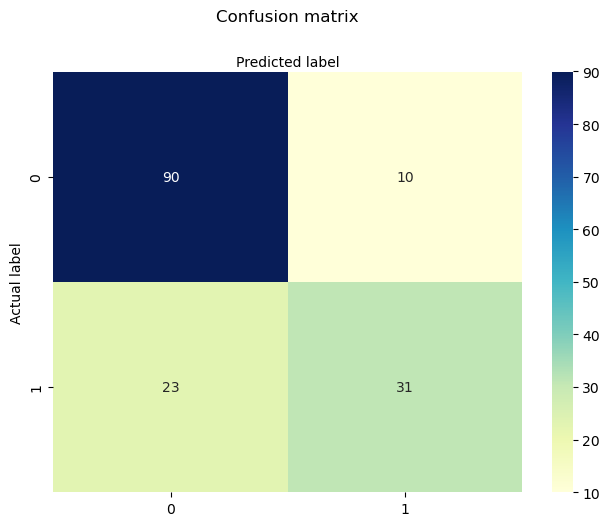

In [38]:
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### we can observe 102 times actual and predicted values are same while 52 times they are not. So the accuracy usinf confusion matrix will be

In [39]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test.round(), y_pred_class))

0.7857142857142857
0.7857142857142857


## Recall 
#### It is a measure of how many truly relevant results are returned. 

In [40]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test.round(), y_pred_class))

0.5740740740740741
0.5740740740740741


## Precision
#### When a positive value is predicted, how often is the prediction correct?
#### How "precise" is the classifier when predicting positive instances?

In [41]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test.round(), y_pred_class))

0.7560975609756098
0.7560975609756098


### predict diabetes if the predicted probability is greater than 0.3


In [42]:
y_pred_class = binarize(y_pred_prob.reshape(1, -1), threshold=0.3)[0]

## ROC Curves and Area Under the Curve (AUC)

In [43]:
# first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test.round(), y_pred_prob)

In [44]:
print(fpr[1:10])
print(tpr[1:10])
print(thresholds[1:10])

[0.   0.   0.01 0.01 0.04 0.04 0.06 0.06 0.07]
[0.01851852 0.24074074 0.24074074 0.33333333 0.33333333 0.44444444
 0.44444444 0.46296296 0.46296296]
[0.9689846  0.81157936 0.8109933  0.76553787 0.75989662 0.70428139
 0.66012403 0.65873093 0.64986255]


#### Area under the curve

In [45]:
auc=metrics.roc_auc_score(y_test.round(), y_pred_prob)
print(auc)

0.8553703703703703


#### Plot ROC Curve

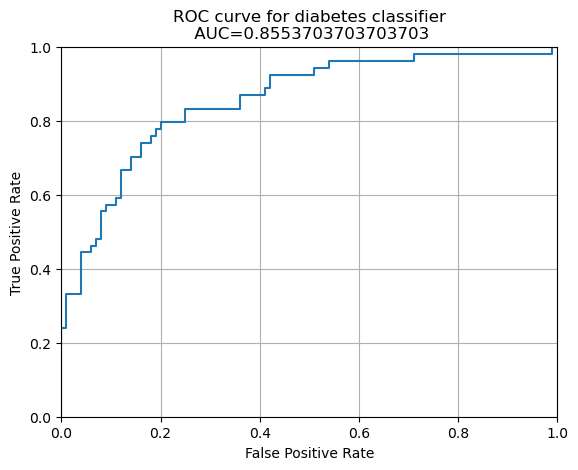

In [46]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier\n AUC={auc}'.format(auc=metrics.roc_auc_score(y_test.round(), y_pred_prob)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

#### define a function that accepts a threshold and prints TP and FP rates

In [47]:

def evaluate_threshold(threshold):
    print('True Positive Rate:', tpr[thresholds > threshold][-1])
    print('False Positive Rate:', fpr[thresholds > threshold][-1])

    # Reshape y_pred_prob to 2D and use keyword argument for threshold
    y_pred_class = binarize(np.array(y_pred_prob).reshape(1, -1), threshold=threshold)[0]
    
    print('Accuracy:', metrics.accuracy_score(y_test.round(), y_pred_class))


## AUC
AUC is the percentage of the ROC plot that is underneath the curve:

In [48]:
print(metrics.roc_auc_score(y_test.round(), y_pred_prob))

0.8553703703703703


## Lasso Regression

In [49]:
clf = Lasso(alpha=0.1)
cv_scores = cross_val_score(clf, X, y.round(), cv=10, scoring='roc_auc')
print(cv_scores)
print(cv_scores.mean())
print(cv_scores.std())

[nan nan nan nan nan nan nan nan nan nan]
nan
nan


#### try lambda=0.0001 through lambda=2 and record testing accuracy

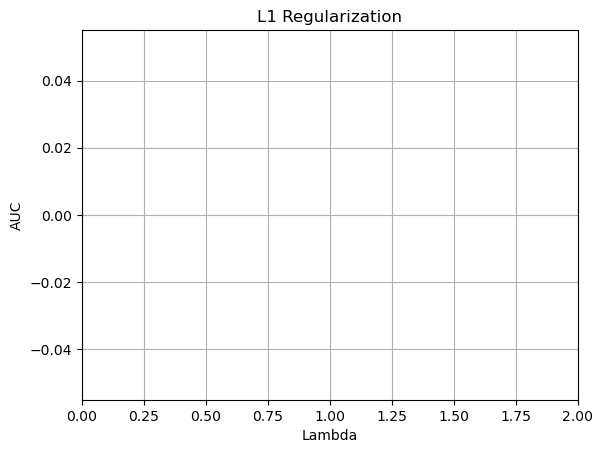

In [52]:
lambda_range = np.arange(0.00001, 1, 0.01)
scores = []
for lam in lambda_range:
    logreg_lasso = Lasso(alpha=lam)
    scores.append(cross_val_score(logreg_lasso, X, y.round(), cv=5, scoring='roc_auc').mean())


plt.plot(lambda_range, scores)
plt.xlim([0.0, 2])
#plt.ylim([0.0, 1.0])
plt.title('L1 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

## Ridge Regression

In [53]:
clf = RidgeClassifier(alpha=0.1)

cv_scores = cross_val_score(clf, X, y.round(), cv=10, scoring='roc_auc')
print(cv_scores.mean())
print(cv_scores.std())

0.8299336349924585
0.040459576943732214


#### try lambda=0.0001 through lambda=2 and record testing accuracy

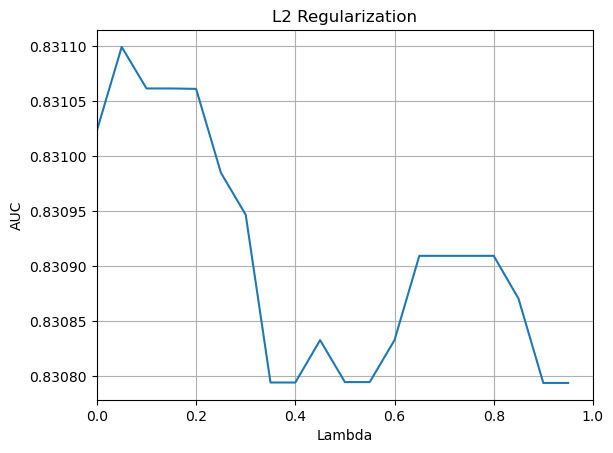

In [54]:
lambda_range = np.arange(0.00001, 1, 0.05)
scores = []
for lam in lambda_range:
    logreg_ridge = RidgeClassifier(alpha=lam)
    scores.append(cross_val_score(logreg_ridge, X, y.round(), cv=5, scoring='roc_auc').mean())

import matplotlib.pyplot as plt

plt.plot(lambda_range, scores)
plt.xlim([0.0, 1])
#plt.ylim([0.0, 1.0])
plt.title('L2 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

## Maximum accuracy achieved is 83.83%